### Part I: FilmTrust data set

- Using the load_from_file capability in Surprise, load the Filmtrust data from the file filmtrust.txt. Note that you will need to supply the rating_scale parameter (05, 4).

- Extract the raw ratings and convert to a Pandas data frame with columns: User, Item, Rating, Unused. (The timestamp column is not present in this data set.)

- Produce a histogram (pyplot.hist) of the item distribution. The x-axis should be the number of times that an item has been rated; the y-axis should be a log axis and should represent the number of items with that number of ratings.

- Do the same for the user rating distribution (essentially, the size of each user's profile).
Finally, produce histogram showing the rating distribution at each rating level. Legal rating levels in this data set start at 0.5 and go up to 4 in steps of 0.5.

### Part II: Implement significance weighting

- Starting from the existing KNNSigWeighting class in the sigweight.py file, implement significance weighting for the KNNWithMeans algorithm. This will require the following steps

- Modify the fit() function to create and populate a numpy matrix self.overlap of rating overlap counts. The value in each cell [i,j] should correspond to the number of items that user i and user j have rated in common. The diagonal [i,i] should be zero.

- Create a class function sig_weight(x1, x2) that computes the significance weight of two users given the overlap matrix calculated in the fit() function and a corate_threshold value that is passed in as one of the sim_option arguments.

- Modify the fit() function to iterate through the sim matrix and replace each entry with the value discounted by the weight returned by sig_weight. In other words: sim[i , j] = sim[i, j] * self.sig_weight(i, j) for all i, j in the sim matrix.
- Verify that your implementation is correct by running the unit tests at the end of the sigweight.py file.

### Part III: Experiments
- Verify your implementation with the Test Code 
- Compare your implementation of KNN with significance weighting with KNNWithMeans using RMSE
- Use the user-based formulation and Pearson correlation in all cases.
- Use corate_threshold of 100 and 50 (default).
- Use 5-fold cross-validation.
- Produce a boxplot of the RMSE values
- Compare the three implementations using the (non-standard) recall / precision implementation provided by the Surprise developers.


In [1]:
import pandas as pd
import scipy as sp
from scipy.stats import ttest_rel
import numpy as np
from matplotlib import pyplot as plt
import heapq
import warnings
warnings.filterwarnings('ignore')

#### *1-2. Import from Surprise*

In [2]:
from surprise import KNNWithMeans
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, KFold, ShuffleSplit
from surprise.prediction_algorithms import PredictionImpossible

#### *1-3. Import from local code*

In [3]:
%load_ext autoreload
%autoreload
from sigweight1 import KNNSigWeighting
from prec_recall import pr_eval, precision_recall_at_k

### Step 2 Load the "Filmtrust" data
#### *2-1. First load using Surprise*

In [4]:
import os
file_path = os.path.expanduser('~/Desktop/filmtrust.txt')
reader = Reader(rating_scale = (0.5, 4))
#reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_from_file(file_path, reader=reader)
data.raw_ratings

[('1050', '215', 3.0, None),
 ('1050', '250', 2.0, None),
 ('1050', '251', 2.5, None),
 ('1051', '213', 3.0, None),
 ('1051', '241', 3.5, None),
 ('1051', '5', 4.0, None),
 ('1051', '7', 3.5, None),
 ('1051', '206', 4.0, None),
 ('1051', '220', 3.0, None),
 ('1051', '520', 4.0, None),
 ('1051', '17', 3.0, None),
 ('1051', '2', 4.0, None),
 ('1051', '235', 3.5, None),
 ('1051', '1359', 4.0, None),
 ('1051', '236', 3.0, None),
 ('1051', '12', 2.5, None),
 ('1051', '9', 3.5, None),
 ('1051', '121', 3.0, None),
 ('1051', '216', 3.0, None),
 ('1051', '255', 3.5, None),
 ('1051', '234', 3.5, None),
 ('1051', '211', 3.5, None),
 ('1052', '206', 2.5, None),
 ('1052', '217', 0.5, None),
 ('1052', '9', 3.0, None),
 ('1052', '215', 4.0, None),
 ('1052', '213', 2.5, None),
 ('1052', '205', 4.0, None),
 ('1052', '255', 3.0, None),
 ('1052', '214', 2.5, None),
 ('1052', '245', 1.5, None),
 ('1052', '239', 2.5, None),
 ('1052', '234', 1.5, None),
 ('1052', '3', 1.5, None),
 ('1052', '2', 3.5, None),


#### *2-2. Convert to a data frame*

In [5]:
col = ['User','Item','Rating','Unused']
df = pd.DataFrame(data.raw_ratings, columns = col)
print(df.shape)
df.head()

(35497, 4)


,User,Item,Rating,Unused
0,1050,215,3.0,None
1,1050,250,2.0,None
2,1050,251,2.5,None
3,1051,213,3.0,None
4,1051,241,3.5,None


### Step 3 Get data set stats
#### *3-1. Group by item and count to get item rating distribution*

In [6]:
group_item = df.groupby('Item')['Rating'].count()
group_item.head(10)

Item
1       866
10      750
100       6
1000      1
1001      3
1002      4
1003      3
1004      1
1005      1
1006      3
Name: Rating, dtype: int64

#### *3-2. Plot item rating distribution (use log y axis)*

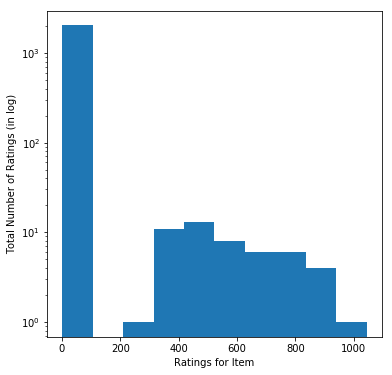

In [7]:
%matplotlib inline
plt.figure(figsize = (6,6))
plt.hist(group_item)
plt.yscale('log')
plt.xlabel('Ratings for Item')
plt.ylabel('Total Number of Ratings (in log)')
plt.show()

#### *3-3. Group by user and count to get user rating distribution*

In [8]:
group_user = df.groupby('User')['Rating'].count()
group_user.head(10)

User
1       12
10       5
100      1
1000    51
1001    50
1002    29
1003    50
1004    20
1005     3
1006    54
Name: Rating, dtype: int64

#### *3-4. Plot user rating distribution (also log y axis)*

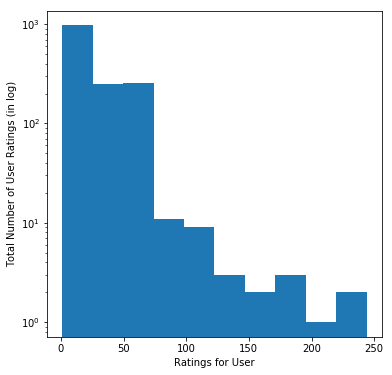

In [9]:
plt.figure(figsize = (6,6))

plt.hist(group_user)
plt.yscale('log')
plt.xlabel('Ratings for User')
plt.ylabel('Total Number of User Ratings (in log)')
plt.show()

#### *3-5. Plot distribution of ratings*

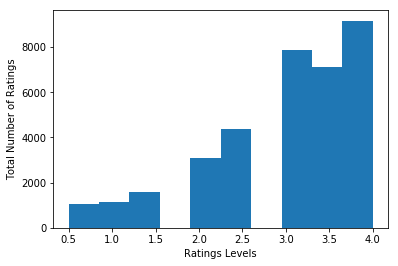

In [10]:
plt.hist(df['Rating'])
plt.xlabel('Ratings Levels')
plt.ylabel('Total Number of Ratings')
plt.show()

### Step 4 Compare algorithms RMSE
Use three algorithms
- regular KNNWithMeans, user-based, Pearson correlation
- significance weighting with corate_threshold=100
- significance weighting with default corate_threshold of 50
Use 5-fold cross-validation
Calculate RMSE only

In [11]:
%autoreload

#### 4-1. *KNNWithMeans*

In [12]:
from surprise.accuracy import rmse 
cv = KFold(n_splits = 5, random_state = 1,shuffle=False)
sim_opt = {'name':'pearson', 'user_based':True}
algo1 = KNNWithMeans(sim_options = sim_opt)
output1 = cross_validate(algo1, data, measures=['RMSE'], cv=cv, verbose=True)

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8821  0.9409  0.9303  0.8956  0.9422  0.9182  0.0247  
Fit time          1.51    1.56    1.59    1.48    1.23    1.47    0.13    
Test time         0.05    0.09    0.05    0.05    0.06    0.06    0.02    


#### *4-2. Significance weighting with corate_threshold = 100*

In [13]:
sim_opt2 = {'name':'pearson', 'user_based':True,'corate_threshold':100}
algo2 = KNNSigWeighting(sim_options = sim_opt2)
output2 = cross_validate(algo2, data, measures=['RMSE'], cv=cv, verbose=True)

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNSigWeighting on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8821  0.9411  0.9304  0.8956  0.9422  0.9183  0.0247  
Fit time          36.70   36.15   36.39   36.14   34.13   35.90   0.91    
Test time         0.04    0.05    0.04    0.04    0.06    0.05    0.01    


#### *4-3. Significance weighting with corate_threshold = 50*

In [14]:
sim_opt3 = {'name':'pearson', 'user_based':True,'corate_threshold':50}
algo3 = KNNSigWeighting(sim_options = sim_opt3)
output3 = cross_validate(algo3, data, measures=['RMSE'], cv=cv, verbose=True)

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNSigWeighting on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8821  0.9411  0.9304  0.8956  0.9422  0.9183  0.0247  
Fit time          36.95   44.00   37.85   39.67   33.88   38.47   3.34    
Test time         0.04    0.05    0.04    0.04    0.05    0.05    0.00    


#### *4-4. Produce a boxplot of the RMSE values. (They are all pretty similar.)*

{'boxes': [<matplotlib.lines.Line2D at 0x1a129ae080>,
 'caps': [<matplotlib.lines.Line2D at 0x1a129e1b70>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a13304f28>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a129e1c18>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a129ae978>,
  <matplotlib.lines.Line2D at 0x1a13317898>]}

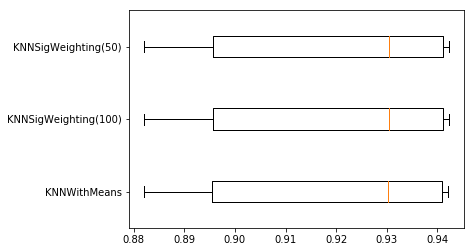

In [15]:
rmse = [output1['test_rmse'], output2['test_rmse'], output3['test_rmse']]
plt.boxplot(rmse, labels=["KNNWithMeans", "KNNSigWeighting(100)", "KNNSigWeighting(50)"], vert=False, )
#plt.xticks([0.800, 0.810, 0.820, 0.830, 0.840])

### Step 5 Compare algorithms precall, precision
Use the same algorithms but compute precision and recall.
Use `pr_eval` from the `prec_recall.py` file. This is more or less the same code as in the Surprise example code, but it returns a Pandas data frame with the results.

#### *5-1. KNNWithMeans*

In [16]:
output4 = pr_eval(algo1, data, cv, n= 10, threshold = 3.3)
output4

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Precision-Recall
{'Fold 1': Precision    0.002090
Recall       0.001254
dtype: float64, 'Fold 2': Precision    0.003118
Recall       0.003272
dtype: float64, 'Fold 3': Precision    0.001799
Recall       0.003597
dtype: float64, 'Fold 4': Precision    0.002907
Recall       0.002584
dtype: float64, 'Fold 5': Precision    0.002295
Recall       0.001043
dtype: float64}


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
Precision,0.002090,0.003118,0.001799,0.002907,0.002295
Recall,0.001254,0.003272,0.003597,0.002584,0.001043


*Create a box plot of the precision values & Boxplot of the recall values*

([<matplotlib.axis.XTick at 0x1a1298b7f0>,
 <a list of 6 Text xticklabel objects>)

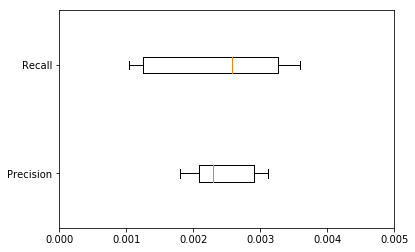

In [17]:
pre_rec = [output4.T['Precision'], output4.T['Recall']]
plt.boxplot(pre_rec, labels=["Precision","Recall"], vert=False, )
plt.xticks([0.0000, 0.0010, 0.0020, 0.0030, 0.0040, 0.0050])

#### *5-2. Significance weighting with corate_threshold = 100*

In [18]:
output5 = pr_eval(algo2, data, cv, n= 10, threshold = 3.3)
output5

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Precision-Recall
{'Fold 1': Precision    0.001567
Recall       0.000627
dtype: float64, 'Fold 2': Precision    0.003306
Recall       0.004147
dtype: float64, 'Fold 3': Precision    0.001199
Recall       0.003597
dtype: float64, 'Fold 4': Precision    0.002658
Recall       0.002953
dtype: float64, 'Fold 5': Precision    0.002951
Recall       0.001341
dtype: float64}


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
Precision,0.001567,0.003306,0.001199,0.002658,0.002951
Recall,0.000627,0.004147,0.003597,0.002953,0.001341


*Create a box plot of the precision values & Boxplot of the recall values*

([<matplotlib.axis.XTick at 0x1a1342af60>,
 <a list of 6 Text xticklabel objects>)

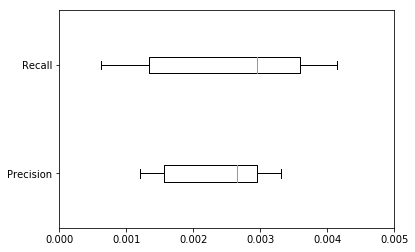

In [19]:
pre_rec = [output5.T['Precision'], output5.T['Recall']]
plt.boxplot(pre_rec, labels=["Precision","Recall"], vert=False, )
plt.xticks([0.0000, 0.0010, 0.0020, 0.0030, 0.0040, 0.0050])

#### *5-3. Significance weighting with corate_threshold = 50*

In [20]:
output6 = pr_eval(algo3, data, cv, n= 10, threshold = 3.3)
output6

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Precision-Recall
{'Fold 1': Precision    0.001567
Recall       0.000627
dtype: float64, 'Fold 2': Precision    0.003306
Recall       0.004147
dtype: float64, 'Fold 3': Precision    0.001199
Recall       0.003597
dtype: float64, 'Fold 4': Precision    0.002658
Recall       0.002953
dtype: float64, 'Fold 5': Precision    0.002951
Recall       0.001341
dtype: float64}


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
Precision,0.001567,0.003306,0.001199,0.002658,0.002951
Recall,0.000627,0.004147,0.003597,0.002953,0.001341


*Create a box plot of the precision values & Boxplot of the recall values*

([<matplotlib.axis.XTick at 0x1a14257828>,
 <a list of 6 Text xticklabel objects>)

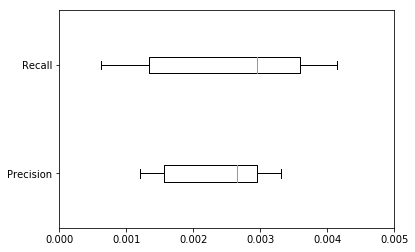

In [21]:
pre_rec = [output6.T['Precision'], output6.T['Recall']]
plt.boxplot(pre_rec, labels=["Precision","Recall"], vert=False, )
plt.xticks([0.0000, 0.0010, 0.0020, 0.0030, 0.0040, 0.0050])

Scatter plot of precision (y) vs recall (x). Include legend. See example below.

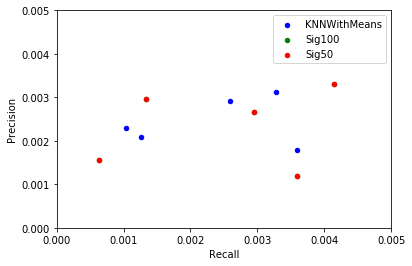

In [22]:
df1 = pd.DataFrame(output4.T, columns = ['Precision', 'Recall'])
df2 = pd.DataFrame(output5.T, columns = ['Precision', 'Recall'])
df3 = pd.DataFrame(output6.T, columns = ['Precision', 'Recall'])

ax1 = df1.plot(kind = 'scatter', x = 'Recall', y = 'Precision', color = 'b', label = 'KNNWithMeans') 
ax2 = df2.plot(kind = 'scatter', x = 'Recall', y = 'Precision', color = 'g', label = 'Sig100',ax = ax1) 
ax3 = df3.plot(kind = 'scatter', x = 'Recall', y = 'Precision', color = 'r', label = 'Sig50',ax = ax1) 

ax1.set_xlim(0,0.005)
ax1.set_ylim(0,0.005)


ax1.legend()
ax2.legend()
ax3.legend()

#output4.plot(kind='scatter', x = output4['Recall'], y=output4['Precision'])

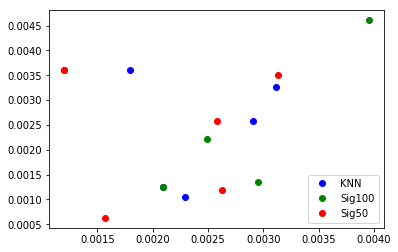

# Test Code
Do not modify. Use this to test your code.

Imports

In [23]:
from surprise.model_selection import PredefinedKFold
from surprise.accuracy import rmse

Read test data

In [24]:
TEST_reader = Reader(line_format='user item rating', sep=',', skip_lines=1)
TEST_train_file = 'test-data-train.csv'
TEST_test_file = 'test-data-test.csv'
TEST_folds_files = [(TEST_train_file, TEST_test_file)]

TEST_data = Dataset.load_from_folds(TEST_folds_files, reader=TEST_reader)

Create single split

In [25]:
TEST_pkf = PredefinedKFold()
TEST_trainset, TEST_testset = next(TEST_pkf.split(TEST_data))

Run algorithm

In [26]:
%autoreload
TEST_algo = KNNSigWeighting(k=3, sim_options={'name': 'pearson', 'user_based': True, 
                                              'corate_threshold': 4.0})
TEST_algo.fit(TEST_trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


Test similarity matrix

In [27]:
TEST_correct_values = [(0,1, 0.375), (4, 3, -0.75), (2, 1, 0.7280)]
TEST_epsilon = 0.0001

for u1, u2, sim in TEST_correct_values:
    if abs(sim - TEST_algo.sim[u1, u2]) < TEST_epsilon:
        print("Your implementation is correct.")
    else:
        print("Your implementation is not correct. Keep working.")

Your implementation is correct.
Your implementation is correct.
Your implementation is correct.
